In [ ]:
#%pip install --upgrade hyperspectral_gta_data

In [22]:
# Common useful packages
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import copy
import spectral

# module that is useful for reloading packages
import importlib

import sys
sys.path.append('/workspaces/Machine-Learning-for-Spectral-Imaging/MyCode/HW/')

sys.path.append('/workspaces/Machine-Learning-for-Spectral-Imaging/Book_Modules/')

# Scripts associated with the SML4SI textbook
import hyperspectral_gta_data as hsi_data
import scripts_M2 as sm2

# set the directory where data will be downloaded and accessed
# (This directory will be saved in a config file and used each time you use hyperspectral_gta_data, 
# so you don't need to run the 'set_data_dir' function every time you use hyperspectral_gta_data.)
hsi_data.set_data_dir('/workspaces/Machine-Learning-for-Spectral-Imaging/spectral_data/')

## In this notebook, we will introduce target detection.

With target detection, we have two data sets:
1. **A hyperspectral image.**
2. **Target spectra.**

The target spectra are usually collected from known materials that we want to find in the iamge.

The data preparation includes:
1. **Load Data:** Load the image and spectral library.
2. **Check Data Scale:** Check that the iamge and library have the same scale. Ideally, they are both on a 0-1 scale for reflectance units, but:
    i. Sometimes data are stored in 16-bit integer data type to save memory and resources.  In that case, they are often on a 0-1000 scale.
    ii. Often, the values for spectral data are too large or small due to (1) changes in sunlight and shadow, (2) problems in atmospherice correction, converting from radiance to reflectance, or (3) calibration of sensors.
3. **Check Wavelengths:** Check that the image and spectra have wavelengths in the same units (both nanometers or both micrometers) and have the same values.  If the units are different, we simply multiply or divide by 1000 as needed.  If the wavelength values are different, we have to resample the data. Almost always, this means resampling the library to the wavelengths of the image, because the library usually has higher spectral resolution (more bands with more tightly-spaced wavelengths).
4. **Quality Check:** Do a quality check on the data and spectra.  If the light source for either is the sun, then there will be bands where the atmosphere (mostly water vapor) absorbs most of the light.  These need to be removed from the data, and then the resampling is needed as in Step 3.

After these are completed, we will be ready for target deteciton.

# 1. Download the data

In [3]:
# Here are the datasets available through the hyperspectral_gta_data package
hsi_data.available_datasets()

Available Images:
   WashingtonDC
   MicroscenePolymers
   Detection_Imagery_Cooke_City_RIT
   VegBaccharisUPWINS
   PaintDetectionUPWINS
   indian_pines
   pavia_centre
   pavia_university
Available Spectral Libraries:
   GHISACONUS_2008_001_speclib
   Microscene_Polymers_Library
   UPWINS_4_16_2024
   Detection_Library_Cooke_City_RIT


## Download the hyperspectral image

In this case, we will be using a hyperspectral image from the RIT test over Cooke City, Montana. (https://dirsapps.cis.rit.edu/blindtest/)

In [4]:
# Download and use the Cooke Cite image:
hsi_data.download('VegBaccharisUPWINS')
fname = hsi_data.get_fname('VegBaccharisUPWINS')

Available Files:
/workspaces/Machine-Learning-for-Spectral-Imaging/spectral_data/spectral_images/Vegetation_Baccharis_halmifolia_UPWINS/Morven_Baccharis_h_or_ref.hdr
/workspaces/Machine-Learning-for-Spectral-Imaging/spectral_data/spectral_images/Vegetation_Baccharis_halmifolia_UPWINS/Morven_Baccharis_h_or_ref
Primary Image Filename:
/workspaces/Machine-Learning-for-Spectral-Imaging/spectral_data/spectral_images/Vegetation_Baccharis_halmifolia_UPWINS/Morven_Baccharis_h_or_ref


In [5]:
# load the UPWINS hyperspectral iamge
fname = '/workspaces/Machine-Learning-for-Spectral-Imaging/spectral_data/spectral_images/Vegetation_Baccharis_halmifolia_UPWINS/Morven_Baccharis_h_or_ref'
fname_hdr = '/workspaces/Machine-Learning-for-Spectral-Imaging/spectral_data/spectral_images/Vegetation_Baccharis_halmifolia_UPWINS/Morven_Baccharis_h_or_ref.hdr'

# Open the image and read into an array
im = spectral.envi.open(fname_hdr, fname)
wl_im = np.asarray(im.bands.centers)
# Load the image into memory
im.Arr = im.load()
imArr = im.Arr
print(f'Shape of ImArr = {imArr.shape}')
imList = np.reshape(imArr, (im.nrows*im.ncols, im.nbands))
print(f'Shape of imList = {imList.shape}')

Shape of ImArr = (300, 600, 343)
Shape of imList = (180000, 343)


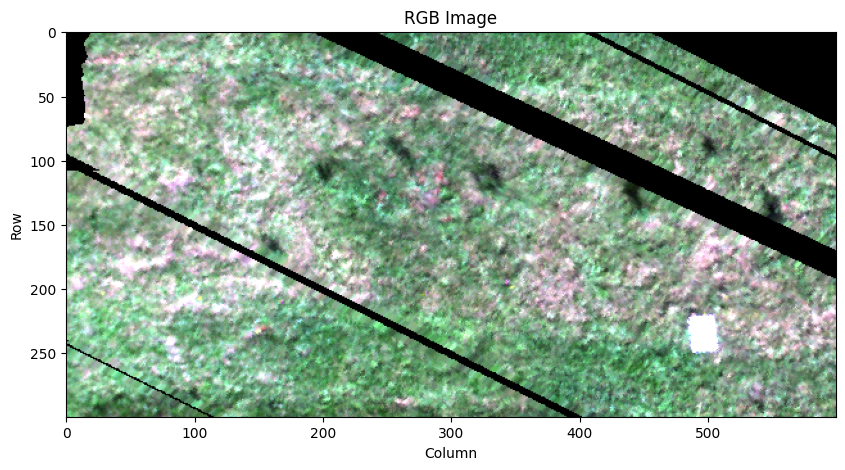

In [6]:
# display the image
sm2.display_RGB(imArr, wl_im, rotate=False)
plt.title('RGB Image');

In [ ]:
# explore the image in our hyperspectral image viewer
from hsiViewer import hsi_viewer as hv
#hv.viewer(im)

# Download the Spectral Library fopr Target Detection

In [7]:
# To download and use the Cooke City spectral library image:
hsi_data.download('UPWINS_4_16_2024')
fname = hsi_data.get_fname('UPWINS_4_16_2024')

Downloading...
From: https://drive.google.com/uc?id=11Zn-DxlVevtg-KAKnDRiPEVxnLYXDl5h
To: /workspaces/Machine-Learning-for-Spectral-Imaging/spectral_data/spectral_libraries/UPWINS_4_16_2024.zip
100%|██████████| 6.88M/6.88M [00:03<00:00, 2.03MB/s]

File saved as: /workspaces/Machine-Learning-for-Spectral-Imaging/spectral_data/spectral_libraries/UPWINS_4_16_2024/UPWINS_4_16_2024.hdr
File saved as: /workspaces/Machine-Learning-for-Spectral-Imaging/spectral_data/spectral_libraries/UPWINS_4_16_2024/UPWINS_4_16_2024.sli
 
Available Files:
/workspaces/Machine-Learning-for-Spectral-Imaging/spectral_data/spectral_libraries/UPWINS_4_16_2024/UPWINS_4_16_2024.sli
/workspaces/Machine-Learning-for-Spectral-Imaging/spectral_data/spectral_libraries/UPWINS_4_16_2024/UPWINS_4_16_2024.hdr
Primary Image Filename:
/workspaces/Machine-Learning-for-Spectral-Imaging/spectral_data/spectral_libraries/UPWINS_4_16_2024/UPWINS_4_16_2024.sli


In [12]:
fname = '/workspaces/Machine-Learning-for-Spectral-Imaging/spectral_data/spectral_libraries/UPWINS_4_16_2024/UPWINS_4_16_2024.sli'
fname_hdr = '/workspaces/Machine-Learning-for-Spectral-Imaging/spectral_data/spectral_libraries/UPWINS_4_16_2024/UPWINS_4_16_2024.hdr'

# Open the image and read into an array
lib = spectral.envi.open(fname_hdr, fname)
wl = np.asarray(im.bands.centers)
# Load the image into memory
names = lib.names
spectra = lib.spectra
wl_lib = np.asarray(lib.bands.centers)

In [13]:
names

['Baccharis_Halimif_L_Y1G_H00000',
 'Baccharis_Halimif_L_Y1G_H00001',
 'Baccharis_Halimif_L_Y1G_H00002',
 'Baccharis_Halimif_L_Y1G_H00003',
 'Baccharis_Halimif_L_Y1G_H00004',
 'Baccharis_Halimif_L_Y1G_H00005',
 'Baccharis_Halimif_L_Y1G_H00006',
 'Baccharis_Halimif_L_Y1G_H00007',
 'Baccharis_Halimif_L_Y1G_H00008',
 'Baccharis_Halimif_L_Y1G_H00009',
 'Baccharis_Halimif_L_Y1G_H00010',
 'Baccharis_Halimif_L_Y1G_H00011',
 'Baccharis_Halimif_L_Y1G_H00012',
 'Baccharis_Halimif_L_Y1G_H00013',
 'Baccharis_Halimif_L_Y1G_H00014',
 'Baccharis_Halimif_L_Y1G_H00015',
 'Baccharis_Halimif_L_Y1G_H00016',
 'Baccharis_Halimif_L_Y1G_H00017',
 'Baccharis_Halimif_L_Y1G_H00018',
 'Baccharis_Halimif_L_Y1G_H00019',
 'Baccharis_Halimif_L_Y1G_H00020',
 'Baccharis_Halimif_RS_Y1G_H00000',
 'Baccharis_Halimif_RS_Y1G_H00001',
 'Baccharis_Halimif_RS_Y1G_H00002',
 'Baccharis_Halimif_SA_Y1G_H00000',
 'Baccharis_Halimif_SA_Y1G_H00001',
 'Baccharis_Halimif_SA_Y1G_H00002',
 'Baccharis_halimifoli_L_RE_H00000',
 'Baccharis_

# Check Data Scale

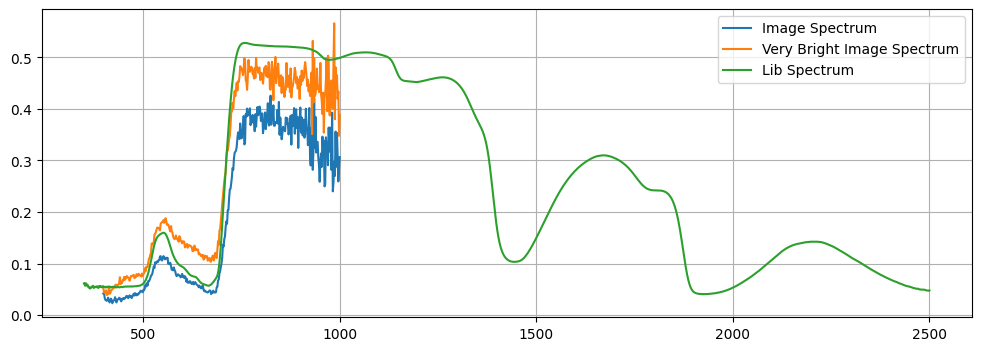

In [14]:
plt.figure(figsize=(12,4))
plt.plot(wl_im, imArr[100,100,:].flatten(), label='Image Spectrum')
plt.plot(wl_im, imArr[172,233,:].flatten(), label='Very Bright Image Spectrum')
plt.plot(wl_lib, spectra[5,:].flatten(), label='Lib Spectrum')
plt.grid()
plt.legend()

### Observation: The image spectra and library spectra appear to be approximately on the same scale. It looks like 100% reflectance corresponds to about 6000.  This value doesn't matter much as long as they are on similar scales.

# Check wavelengths

In [15]:
print(f'Number of image wavelengths: {len(wl_im)}.')
print(f'Number of library wavelengths: {len(wl_lib)}.')
print('')
print(f'First 10 image wavelengths: {wl_im[:10]}.')
print('')
print(f'First 10 library wavelengths: {wl_lib[:10]}.')

Number of image wavelengths: 343.
Number of library wavelengths: 2151.

First 10 image wavelengths: [399.096008 400.854004 402.612    404.369995 406.127991 407.885986
 409.644012 411.403015 413.161011 414.919006].

First 10 library wavelengths: [350. 351. 352. 353. 354. 355. 356. 357. 358. 359.].


### Observation: The library spectrum has many more wavelengths than the image.  Also, there is about 14nm between succsive image wavelength and about 1nm between library wavelengths.

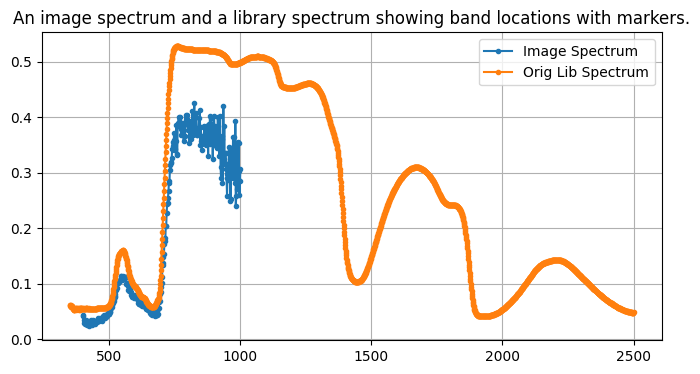

In [16]:
plt.figure(figsize=(8,4))
plt.title('An image spectrum and a library spectrum showing band locations with markers.')
plt.plot(wl_im, imArr[100,100,:].flatten(), marker='.', label='Image Spectrum')
plt.plot(wl_lib, spectra[5,:].flatten(), marker='.', label='Orig Lib Spectrum')
plt.grid()
plt.legend()

### Resampling the library wavelength to match the image.

In [17]:
# Create a BandResampler, which is a function that resamples spectra from one source to match a different source.
# See: https://www.spectralpython.net/class_func_ref.html?highlight=resampling#spectral.algorithms.resampling.BandResampler
# Inputs: the first input is the wavelengths for the spectra that you are going to resample, the second input is the wavelevngths that you want to resample to.
resampler = spectral.BandResampler(wl_lib, wl_im)
spectra_resampled = resampler(lib.spectra.T).T

print(f'The shape of the spectral library is {spectra_resampled.shape}.')
print(f'({spectra_resampled.shape[0]} spectra with {spectra_resampled.shape[1]} bands.)')

The shape of the spectral library is (938, 343).
(938 spectra with 343 bands.)


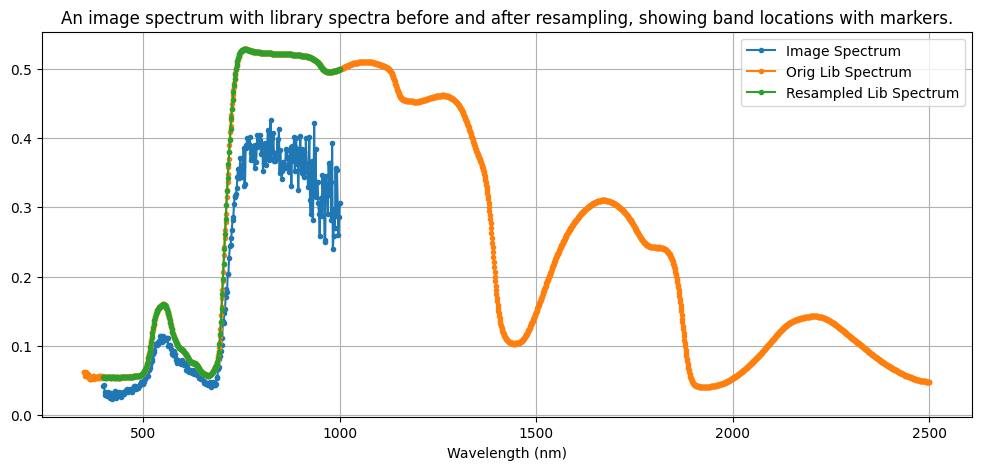

In [18]:
plt.figure(figsize=(12,5))
plt.title('An image spectrum with library spectra before and after resampling, showing band locations with markers.')
plt.plot(wl_im, imArr[100,100,:].flatten(), marker='.', label='Image Spectrum')
plt.plot(wl_lib, spectra[5,:].flatten(), marker='.', label='Orig Lib Spectrum')
plt.plot(wl_im, spectra_resampled[5,:].flatten(), marker='.', label='Resampled Lib Spectrum')
plt.xlabel('Wavelength (nm)')
plt.grid()
plt.legend();

In [19]:
# now that the library is resampled, let's use simple names.
spec = spectra_resampled # spectra from the library, after resampling
wl = wl_im # the wavelengths for the image and the resampled library

# Matched Filter Target Detection
1. Compute the mean and covariance.
2. Whiten the image and target spectra.
3. Compute the Matched Filter score for each pixel:
$$
    MF(x) = \frac{\r{x}^T \r{t}}{\r{t}^T \r{t}}
$$
where $\r{x}$ is a whitened pixel spectrum and $\r{t}$ is the whitened target spectrum. 

We showed in class that computing $MF(x)$ is derived by assuming we have a non-target class (or background class) and a target class whose distributions are given by
$$
x \sim \mathcal{N}(\mu,\Sigma), x \sim \mathcal{N}t,\Sigma)
$$ 
where $\mu$ and $\Sigma$ are computed from the image and $t$ is the target spectrum.  The $MF(x)$ score is then equivalent to the log-likelihood ratio test using these destributions  Specificially, that
$$
MF(x) = A \times \ln\left(\frac{l(x;\mu,\Sigma)}{l(x;t,\Sigma)}\right) + B
$$
for some constants $A$ and $B$, and where $l(x;\mu,\Sigma)$ is the multivaraite normal distribution likelihood function
$$
l(x;\mu,\Sigma)= \frac{1}{(2\pi)^{k/2}{|\Sigma|}^{-1}}\exp\left(-\frac{1}{2} (x-\mu)^T\Sigma^{-1}(x-\mu)\right).
$$

[the above ratio should be flipped, I think]

## 1. Compute the mean and covariance.

In [8]:
C = np.cov(imList, rowvar=False) # each pixel is an observation, and each band is a variable. The default behavior of np.cov() is rowvar=True, which assumes rows are variables. 
m = np.mean(imList, axis=0)

In [7]:
C.shape

(126, 126)

## 2. Whiten the Image

In [9]:
# Compute the eigenvectors, eigenvalues, and whitening matrix
evals,evecs = np.linalg.eig(C)
# truncate the small eigenvalues to stablize the inverse, if needed
#evals[evals<tol] = tol
DiagMatrix = np.diag(evals**(-1/2)) # dividing by the sqrt of each eval scales (normalizes) the spread (variance) of the data in the direction of each evec to 1
W = np.matmul(evecs,DiagMatrix)
ImListDemean = imList - m

#The goal of whitening is to transform the data so that it has unit variance along all dimensions and the dimensions are uncorrelated. We achieve this by:
#Rotating the data: Multiplying the data by the eigenvector matrix (evecs) rotates the data so that the principal components align with the coordinate axes.
#Scaling the data: After rotation, each dimension's variance corresponds to an eigenvalue. To get unit variance, we need to scale each dimension by the inverse square root of the corresponding eigenvalue.
# This is why we compute evals**(-1/2). Dividing by the square root of the eigenvalue scales the variance to 1.
# Recall that to calculate correlation, we normalize the covariance by dividing by the stdev (covariance divided by the product of the standard deviations of the two variables involved)

print(W.shape)
print(ImListDemean.shape)

#WimList = np.matmul(W.T, ImListDemean.T).T
WimList = np.matmul(ImListDemean, W)

#print(WimList.shape, WimList[:10])
#print(WimList2.shape, WimList2[:10])


(126, 126)
(224000, 126)


## 3. Whiten the spectral library

In [10]:
SpecDemean = spec - m
#Wspec = np.matmul(W.T, SpecDemean.T).T
Wspec = np.matmul(SpecDemean, W)

## 4. Compute the values for MF efficiently.

In [11]:
print(f'Whitened pixel array shape: {WimList.shape}.')
print(f'Whitened target library array shape: {Wspec.shape}.')
ntargets = Wspec.shape[0]

Whitened pixel array shape: (224000, 126).
Whitened target library array shape: (18, 126).


We will compute the value of $MF(x)$ for every pixel and every target spectra efficiently using matrix multiplication.  We compute the numerator (of shape (nPix)x(nTargets)=(224,000)x(18)) and denominator (of shape (nTargets)=(18)) seperately, and then divide them.  The matrix multiplication showing the spectra is shown below.

$$
\textrm{Numerator} = 
\left[
  \begin{array}{ccc}
    {\rule[.5ex]{2.5ex}{0.5pt}} & \r{x}^{T}_{1} & {\rule[.5ex]{2.5ex}{0.5pt}} \\
    {\rule[.5ex]{2.5ex}{0.5pt}} & \r{x}^{T}_{2} & {\rule[.5ex]{2.5ex}{0.5pt}} \\
    {\rule[.5ex]{2.5ex}{0.5pt}} & \vdots & {\rule[.5ex]{2.5ex}{0.5pt}} \\
    {\rule[.5ex]{2.5ex}{0.5pt}} & \r{x}^{T}_{224,000} & {\rule[.5ex]{2.5ex}{0.5pt}} \\  
  \end{array}
\right]
\left[
  \begin{array}{ccc}
    {\rule[-1ex]{0.5pt}{2.5ex}} & {\rule[-1ex]{0.5pt}{2.5ex}} & {\rule[-1ex]{0.5pt}{2.5ex}} & {\rule[-1ex]{0.5pt}{2.5ex}} \\
    {\r{t}_1} & {\r{t}_2} & \cdots &{\r{t}_{18}} \\
    {\rule[-1ex]{0.5pt}{2.5ex}} & {\rule[-1ex]{0.5pt}{2.5ex}} & {\rule[-1ex]{0.5pt}{2.5ex}} & {\rule[-1ex]{0.5pt}{2.5ex}} \\ 
  \end{array}
\right]
=
\left[
  \begin{array}{ccc}
    \r{x}^{T}_{1}\r{t}_1 & \dots  & \r{x}^{T}_{1}\r{t}_{18}\\
    \vdots & \ddots & \vdots\\
    \r{x}^{T}_{224,000}\r{t}_1 & \dots  & \r{x}^{T}_{224,000}\r{t}_{18}
  \end{array}
\right]
$$


$$
\textrm{Denominator} = 
\left[
  \begin{array}{ccc}
    {\r{t}_{1}}^2 & \cdots  & {\r{t}_{18}}^2\\
  \end{array}
\right]
$$

Then $MF=\frac{Numerator}{Denominator}$ where the division is done by broadcasting the divsion of each row in the Numerator byt the Denomenator.

In [12]:
# The computation is now simple
numerator = np.matmul(WimList,Wspec.T) # We need X dot T / T dot T, which is X'T / T'T; since both vars are row vectors (but the formula assumes column vectors), we need to take the transpose of T to get the proper form
x_dot_t = numerator
print(numerator.shape)
denom = np.sum(Wspec**2, axis=1)
t_dot_t = denom
print(denom.shape)
MF = np.squeeze(numerator / denom)

print(MF.shape)

# Lets reshape this result so we can compare it to the image
MF = np.reshape(MF, (im.nrows, im.ncols, ntargets))

(224000, 18)
(18,)
(224000, 18)


In [13]:
# Computation for ACE

denom1 = np.sqrt(np.sum(WimList**2, axis=1, keepdims=True))
hyp = denom1
print(denom1.shape)
denom2 = np.sqrt(t_dot_t)
sqrt_t_dot_t = denom2
print(denom2.shape)
denom = denom1 * denom2
print(denom.shape)

ACE = numerator / denom

print(ACE.shape)

ACE = np.reshape(ACE, (im.nrows, im.ncols, ntargets))

print(ACE.shape)

(224000, 1)
(18,)
(224000, 18)
(224000, 18)
(280, 800, 18)


In [13]:
# explore the image in our hyperspectral image viewer
from hsiViewer import hsi_viewer_layers as hvl
layers = {}
for i in range(ntargets):
    layers[names[i]] = MF[:,:,i].squeeze()
hvl.viewer(im, layers=layers)

In [14]:
# the detection planes will look better if we only show values > 0
from hsiViewer import hsi_viewer_layers as hvl
layers = {}
for i in range(ntargets):
    MF_layer = MF[:,:,i].squeeze()
    MF_layer[MF[:,:,i].squeeze()<0] = 0
    layers[names[i]] = MF_layer
hvl.viewer(im, layers=layers)

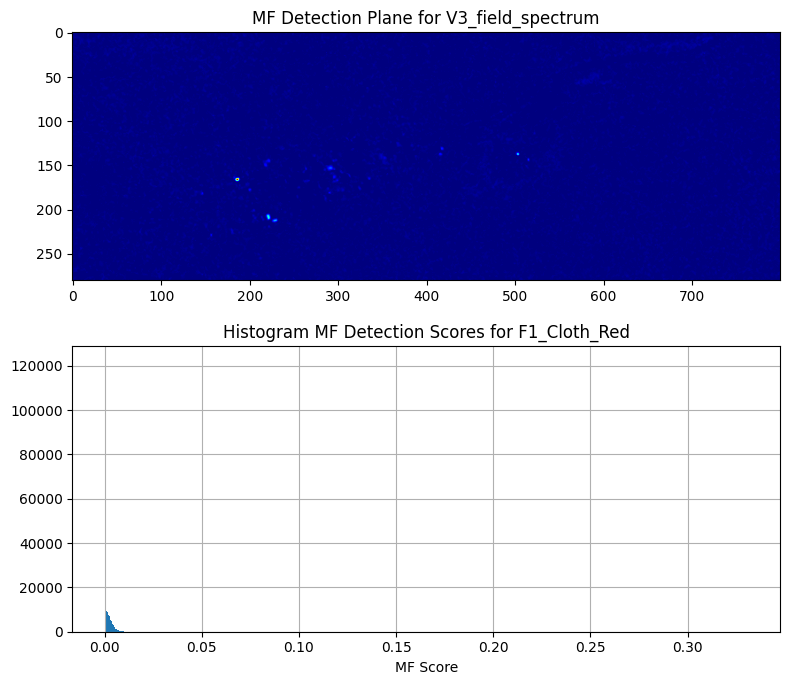

In [20]:
# We can view the results of the matched filter detections for all pixels in the image for a given target, called a 'detection plane' as:
idx = 17
plt.figure(figsize=(8,7))

plt.subplot(2, 1, 1)  
plt.imshow(MF[:,:,idx], cmap='jet')
plt.title(f'MF Detection Plane for {names[0]}')

plt.subplot(2, 1, 2)  
plt.hist(MF[:,:,idx].flatten(), bins=1000);
plt.title(f'Histogram MF Detection Scores for {names[idx]}')
plt.grid(True)
plt.xlabel('MF Score');
plt.tight_layout()

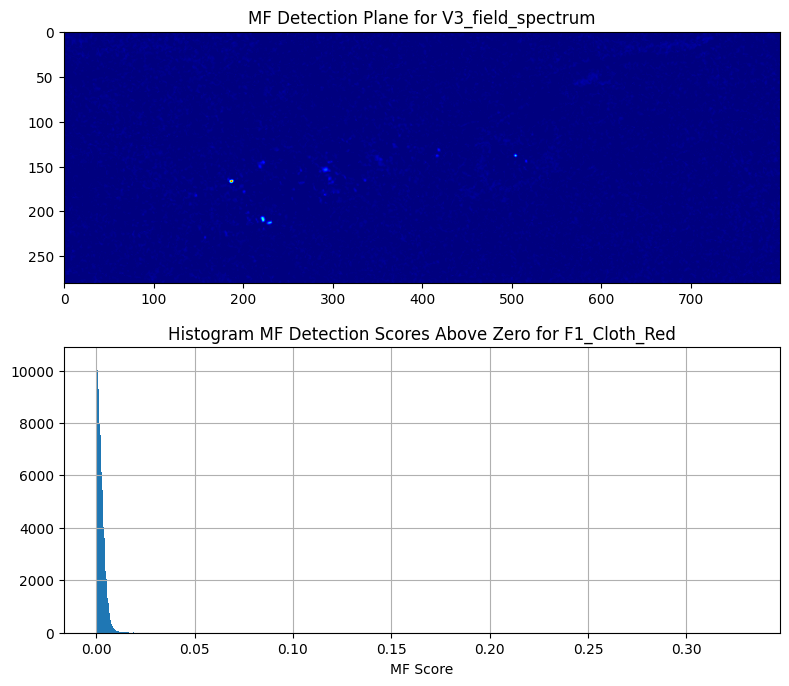

In [19]:
# We can view the results of the matched filter detections for all pixels in the image for a given target, called a 'detection plane' as:
idx = 17
MF_threshold = MF[:,:,idx].squeeze()
MF_threshold[MF_threshold<0] = 0
plt.figure(figsize=(8,7))

plt.subplot(2, 1, 1)  
plt.imshow(MF_threshold, cmap='jet')
plt.title(f'MF Detection Plane for {names[0]}')

plt.subplot(2, 1, 2)  
plt.hist((MF_threshold[MF_threshold>0]).flatten(), bins=1000);
plt.title(f'Histogram MF Detection Scores Above Zero for {names[idx]}')
plt.grid(True)
plt.xlabel('MF Score');
plt.tight_layout()

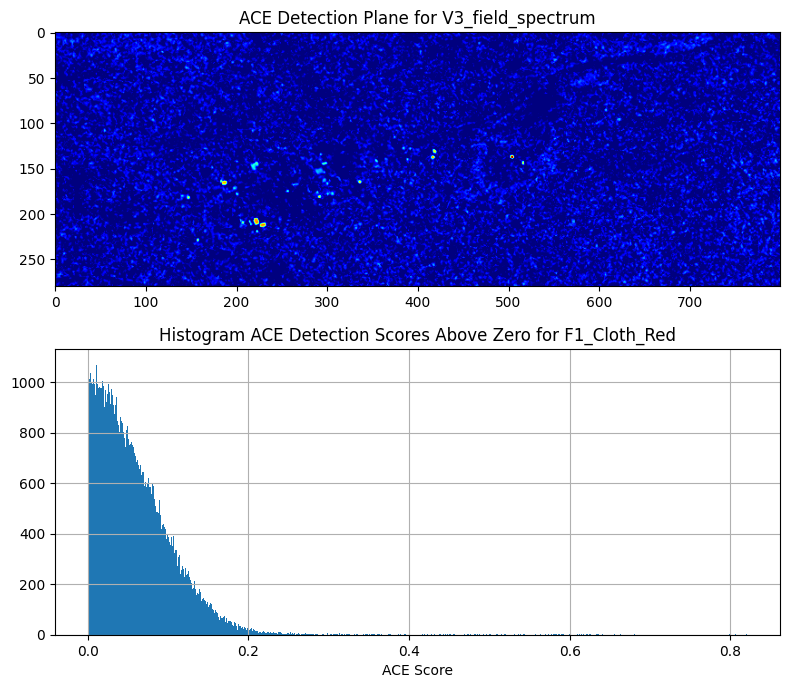

In [21]:
#Ace
# We can view the results of the ace detections for all pixels in the image for a given target, called a 'detection plane' as:
idx = 17
ACE_threshold = ACE[:,:,idx].squeeze()
ACE_threshold[ACE_threshold<0] = 0
plt.figure(figsize=(8,7))

plt.subplot(2, 1, 1)  
plt.imshow(ACE_threshold, cmap='jet')
plt.title(f'ACE Detection Plane for {names[0]}')

plt.subplot(2, 1, 2)  
plt.hist((ACE_threshold[ACE_threshold>0]).flatten(), bins=1000);
plt.title(f'Histogram ACE Detection Scores Above Zero for {names[idx]}')
plt.grid(True)
plt.xlabel('ACE Score');
plt.tight_layout()

<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_669/2299486111.py:46: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f'MF Detections for {names[idx]} Scoring above 6 $\sigma$');


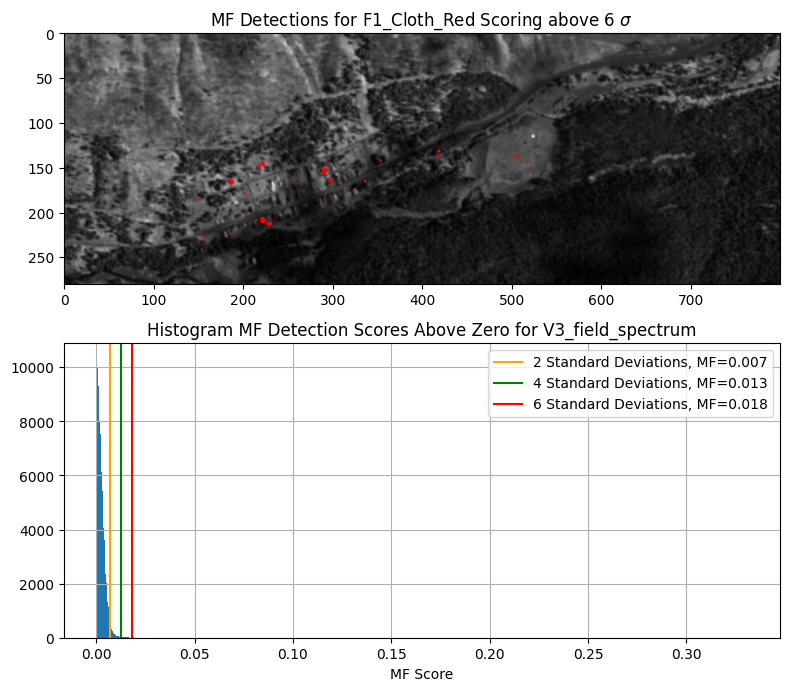

In [22]:
# We can view the results of the matched filter detections for all pixels in the image for a given target, called a 'detection plane' as:
import copy
idx = 17
MF_threshold = MF[:,:,idx].squeeze()
m = np.mean(MF_threshold)
s = np.std(MF_threshold)
MF_threshold[MF_threshold<0] = 0


plt.figure(figsize=(8,7))

plt.subplot(2, 1, 2)  
plt.hist((MF_threshold[MF_threshold>0]).flatten(), bins=1000);
plt.title(f'Histogram MF Detection Scores Above Zero for {names[0]}')
plt.axvline(m+2*s, color='orange', label=f'2 Standard Deviations, MF={(m+2*s):.3f}')
plt.axvline(m+4*s, color='green', label=f'4 Standard Deviations, MF={(m+4*s):.3f}')
plt.axvline(m+6*s, color='red', label=f'6 Standard Deviations, MF={(m+6*s):.3f}')
plt.legend()
plt.grid(True)
plt.xlabel('MF Score');
plt.tight_layout()

# Create an RGB image that is gray at locations without detections, 
# and red on pixels with above 6-standard deviation detection scores.
detections = np.where(MF_threshold>m+6*s)
# get the image band at 750nm, and stretch the values to be in 0-1
band_750 = np.argmin(np.abs(wl-750)) # get the index for the band closest to wl=750
image_detections_singleband = imArr[:,:,band_750].squeeze()
image_detections_singleband = image_detections_singleband - np.min(image_detections_singleband)
image_detections_singleband = image_detections_singleband/np.max(image_detections_singleband)
# build a color RGB image from this one band, making the detection locations red
image_detections_red = copy.deepcopy(image_detections_singleband) # copy here makes a copy of the array, so we don't alter the original array
image_detections_green = copy.deepcopy(image_detections_singleband)
image_detections_blue = copy.deepcopy(image_detections_singleband)
image_detections_red[detections] = 0.99
image_detections_green[detections] = 0
image_detections_blue[detections] = 0
image_detections_RGB = np.zeros((im.nrows,im.ncols,3))
image_detections_RGB[:,:,0] = image_detections_red
image_detections_RGB[:,:,1] = image_detections_green
image_detections_RGB[:,:,2] = image_detections_blue


plt.subplot(2, 1, 1)  
plt.imshow(image_detections_RGB)
plt.title(f'MF Detections for {names[idx]} Scoring above 6 $\sigma$');

<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_669/1888879068.py:47: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f'ACE Detections for {names[idx]} Scoring above 6 $\sigma$');


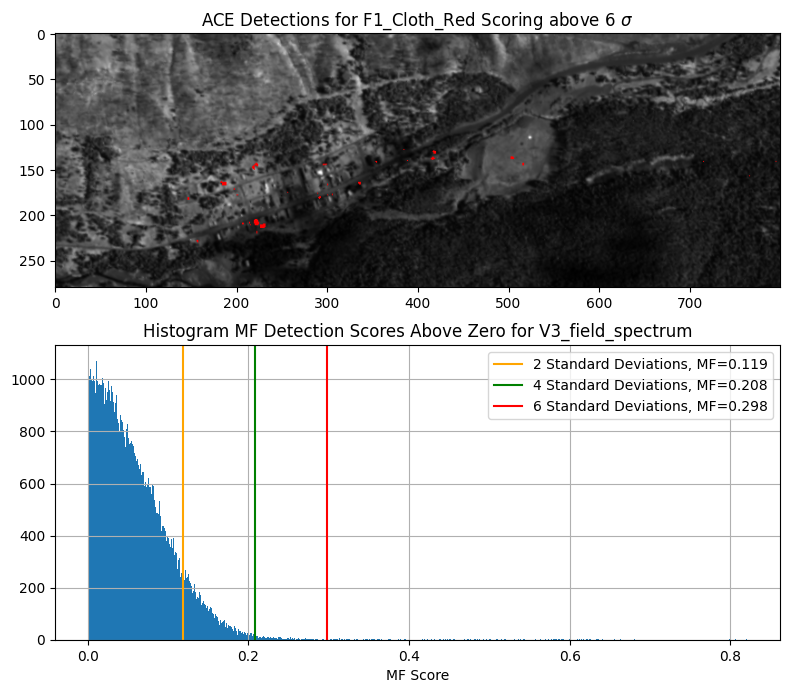

In [ ]:
# ACE
# We can view the results of the matched filter detections for all pixels in the image for a given target, called a 'detection plane' as:
import copy
idx = 17
ACE_threshold = ACE[:,:,idx].squeeze()
m = np.mean(ACE_threshold)
s = np.std(ACE_threshold)
ACE_threshold[ACE_threshold<0] = 0


plt.figure(figsize=(8,7))

plt.subplot(2, 1, 2)  
plt.hist((ACE_threshold[ACE_threshold>0]).flatten(), bins=1000);
plt.title(f'Histogram ACE Detection Scores Above Zero for {names[0]}')
plt.axvline(m+2*s, color='orange', label=f'2 Standard Deviations, ACE={(m+2*s):.3f}')
plt.axvline(m+4*s, color='green', label=f'4 Standard Deviations, ACE={(m+4*s):.3f}')
plt.axvline(m+6*s, color='red', label=f'6 Standard Deviations, ACE={(m+6*s):.3f}')
plt.legend()
plt.grid(True)
plt.xlabel('ACE Score');
plt.tight_layout()

# Create an RGB image that is gray at locations without detections, 
# and red on pixels with above 6-standard deviation detection scores.
detections = np.where(ACE_threshold>m+6*s)
# get the image band at 750nm, and stretch the values to be in 0-1
band_750 = np.argmin(np.abs(wl-750)) # get the index for the band closest to wl=750
image_detections_singleband = imArr[:,:,band_750].squeeze()
image_detections_singleband = image_detections_singleband - np.min(image_detections_singleband)
image_detections_singleband = image_detections_singleband/np.max(image_detections_singleband)
# build a color RGB image from this one band, making the detection locations red
image_detections_red = copy.deepcopy(image_detections_singleband) # copy here makes a copy of the array, so we don't alter the original array
image_detections_green = copy.deepcopy(image_detections_singleband)
image_detections_blue = copy.deepcopy(image_detections_singleband)
image_detections_red[detections] = 0.99
image_detections_green[detections] = 0
image_detections_blue[detections] = 0
image_detections_RGB = np.zeros((im.nrows,im.ncols,3))
image_detections_RGB[:,:,0] = image_detections_red
image_detections_RGB[:,:,1] = image_detections_green
image_detections_RGB[:,:,2] = image_detections_blue


plt.subplot(2, 1, 1)  
plt.imshow(image_detections_RGB)
plt.title(f'ACE Detections for {names[idx]} Scoring above 6 $\sigma$');

# Create ROI Ground Truth


In [23]:
from hsiViewer import hsi_viewer_ROI as hvr
importlib.reload(hvr)
#hvr.viewer(im, stretch=[2,98], rotate=True)

<module 'hsiViewer.hsi_viewer_ROI' from '/workspaces/Machine-Learning-for-Spectral-Imaging/Book_Modules/hsiViewer/hsi_viewer_ROI.py'>

In [24]:
import pickle
fname = '/workspaces/Machine-Learning-for-Spectral-Imaging/Final Project Materials/UPWINS Baccharis Halimifolia.pkl'
with open(fname, 'rb') as f:
    roiData = pickle.load(f)

In [25]:
roiData.names

['Baccharis Halimifolia',
 'Flag',
 'Ribbon',
 'Background Healthy',
 'Background Scenesced']

In [26]:
roiData.colors

{'Baccharis Halimifolia': '#fa3232',
 'Flag': '#fdec02',
 'Ribbon': '#ff43ff',
 'Background Healthy': '#108304',
 'Background Scenesced': '#baae80'}

In [ ]:
roiData.colors['F1']

In [29]:
roiData.masks

{'Baccharis Halimifolia': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'Flag': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'Ribbon': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
  

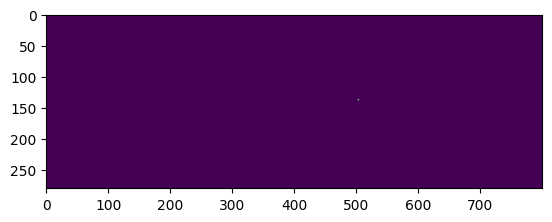

In [53]:
plt.imshow(roiData.masks['F1'])

In [30]:
roiData.df

,Name,Color,Pixel_x,Pixel_y,399.096008,400.854004,402.612,404.369995,406.127991,407.885986,...,984.531006,986.289001,988.047974,989.80603,991.564026,993.322021,995.080017,996.838013,998.596008,1000.349976
0,Baccharis Halimifolia,#fa3232,175,155,0.0282,0.0368,0.0366,0.0344,0.0230,0.0356,...,0.4109,0.3889,0.4285,0.3314,0.3840,0.3716,0.3766,0.3416,0.3801,0.3947
1,Baccharis Halimifolia,#fa3232,174,156,0.0282,0.0368,0.0366,0.0344,0.0230,0.0356,...,0.4109,0.3889,0.4285,0.3314,0.3840,0.3716,0.3766,0.3416,0.3801,0.3947
2,Baccharis Halimifolia,#fa3232,175,156,0.0334,0.0369,0.0309,0.0318,0.0287,0.0324,...,0.4090,0.3906,0.4206,0.3356,0.3441,0.3810,0.3301,0.3485,0.3527,0.3558
3,Baccharis Halimifolia,#fa3232,173,157,0.0282,0.0368,0.0366,0.0344,0.0230,0.0356,...,0.4109,0.3889,0.4285,0.3314,0.3840,0.3716,0.3766,0.3416,0.3801,0.3947
4,Baccharis Halimifolia,#fa3232,174,157,0.0332,0.0369,0.0311,0.0319,0.0285,0.0325,...,0.4091,0.3905,0.4209,0.3354,0.3456,0.3806,0.3319,0.3482,0.3538,0.3573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,Background Scenesced,#baae80,108,172,0.0547,0.0529,0.0493,0.0510,0.0494,0.0515,...,0.3388,0.3305,0.3511,0.3505,0.3243,0.3076,0.3674,0.3502,0.3996,0.3676
250,Background Scenesced,#baae80,104,173,0.0451,0.0459,0.0377,0.0331,0.0342,0.0394,...,0.3737,0.2927,0.3801,0.3776,0.3098,0.4160,0.2905,0.3880,0.3429,0.4168
251,Background Scenesced,#baae80,105,173,0.0460,0.0515,0.0426,0.0450,0.0347,0.0380,...,0.3536,0.3609,0.3262,0.2731,0.3314,0.3233,0.3458,0.3880,0.3494,0.4168
252,Background Scenesced,#baae80,106,173,0.0425,0.0466,0.0452,0.0468,0.0481,0.0403,...,0.2934,0.3556,0.2697,0.3226,0.3806,0.3279,0.3358,0.3361,0.3974,0.2698


# Observing the pixel and library spectra, before and after whitening.

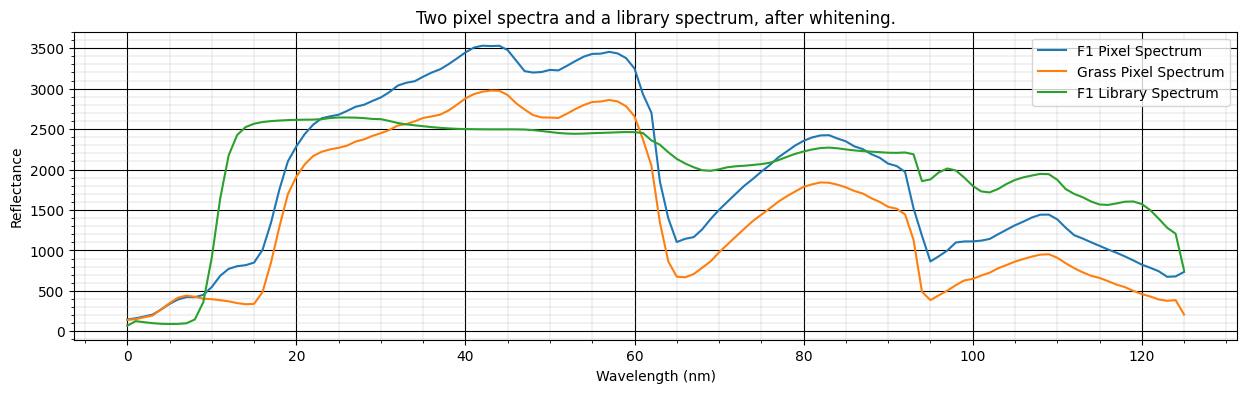

In [18]:
# reshape the whitened image spectra to iamge shape
WimArr = np.reshape(WimList, (im.nrows,im.ncols,im.nbands))
# select the whitened pixel for the pixel containing the red cotton fabric target
F1_idx = [137,503]
pix_F1_Gr = imArr[F1_idx[0], F1_idx[1], :].flatten()
# select the whitened pixel for pure grass
Grass_idx = [139,507]
pix_Gr = imArr[Grass_idx[0], Grass_idx[1], :].flatten()
# select the whitened spectrum from the library for fabric F1
lib_F1 = spec[17,:]

# Plot all three whitened spectra together.  Observe that:
# 1. The grass has small values because it represents a common material (high likelihood).
# 2. The pixel with grass and the red fabric has larger values.
# 3. The library spectrum has very large values because it is very different from materials in the image.
plt.figure(figsize=(15,4))
plt.plot(pix_F1_Gr, label='F1 Pixel Spectrum')
plt.plot(pix_Gr, label='Grass Pixel Spectrum')
plt.plot(lib_F1, label='F1 Library Spectrum')
plt.minorticks_on()
plt.grid(True, which='major', c='k')
plt.grid(True, which='minor', linewidth=0.25)
plt.title('Two pixel spectra and a library spectrum, after whitening.')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend();

In [19]:
print(pix_F1_Gr.shape)

(126,)


In [20]:
# Compute correlations:
pix_F1_Gr_normalized = (pix_F1_Gr-np.mean(pix_F1_Gr))/np.std(pix_F1_Gr)
pix_Gr_normalized = (pix_Gr-np.mean(pix_Gr))/np.std(pix_Gr)
lib_F1_normalized = (lib_F1-np.mean(lib_F1))/np.std(lib_F1)
print(f'pix_Gr to pix_F1 correlation {(1/len(wl))*np.dot(pix_F1_Gr_normalized,pix_Gr_normalized):.3f}')
print(f'pix_Gr to lib_F1 correlation {(1/len(wl))*np.dot(pix_Gr_normalized,lib_F1_normalized):.3f}')
print(f'pix_F1_Gr to lib_F1 correlation {(1/len(wl))*np.dot(pix_F1_Gr_normalized,lib_F1_normalized):.3f}')

pix_Gr to pix_F1 correlation 0.992
pix_Gr to lib_F1 correlation 0.702
pix_F1_Gr to lib_F1 correlation 0.764


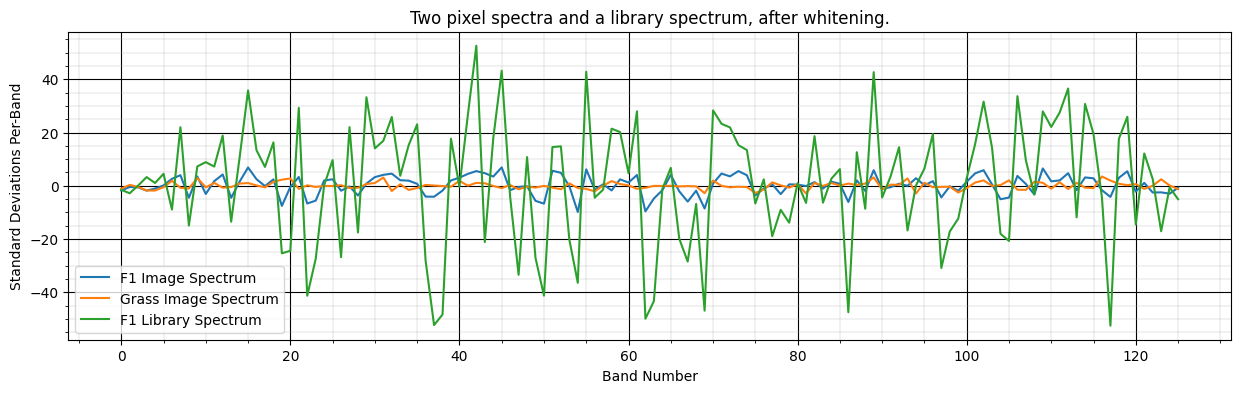

In [21]:
# reshape the whitened image spectra to iamge shape
WimArr = np.reshape(WimList, (im.nrows,im.ncols,im.nbands))
# select the whitened pixel for the pixel containing the red cotton fabric target
F1_idx = [137,503]
WimSpec_F1 = WimArr[F1_idx[0], F1_idx[1], :].flatten()
# select the whitened pixel for pure grass
Grass_idx = [139,507]
WimSpec_Gr = WimArr[Grass_idx[0], Grass_idx[1], :].flatten()
# select the whitened spectrum from the library for fabric F1
Wspec_F1 = Wspec[17,:]

# Plot all three whitened spectra together.  Observe that:
# 1. The grass has small values because it represents a common material (high likelihood).
# 2. The pixel with grass and the red fabric has larger values.
# 3. The library spectrum has very large values because it is very different from materials in the image.
plt.figure(figsize=(15,4))
plt.plot(WimSpec_F1, label='F1 Image Spectrum')
plt.plot(WimSpec_Gr, label='Grass Image Spectrum')
plt.plot(Wspec_F1, label='F1 Library Spectrum')
plt.minorticks_on()
plt.grid(True, which='major', c='k')
plt.grid(True, which='minor', linewidth=0.25)
plt.title('Two pixel spectra and a library spectrum, after whitening.')
plt.xlabel('Band Number')
plt.ylabel('Standard Deviations Per-Band')
plt.legend();

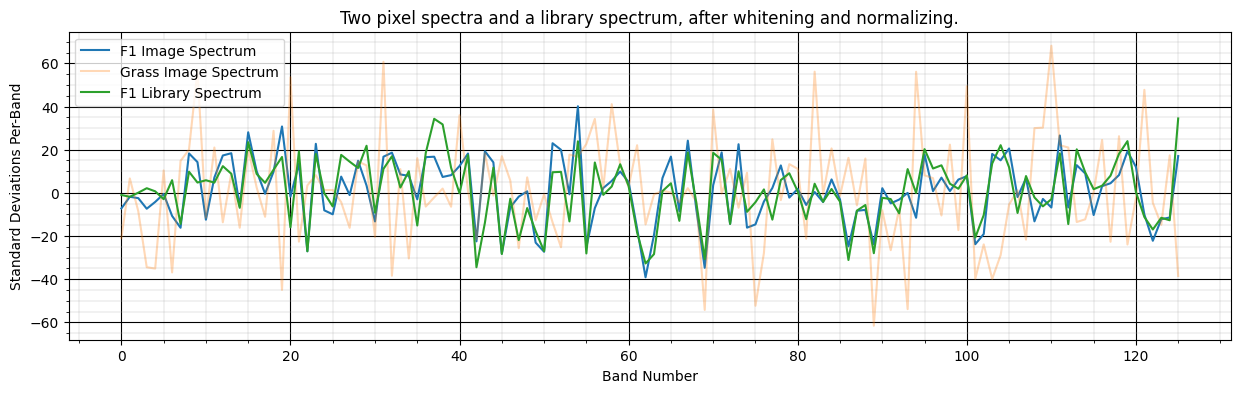

In [30]:
# Recreate the plot, but normalizing the whitened spectra so we can compare the and look for correlation
plt.figure(figsize=(15,4))
plt.plot(WimSpec_F1/np.mean(WimSpec_F1), label='F1 Image Spectrum')
plt.plot(WimSpec_Gr/np.mean(WimSpec_Gr), label='Grass Image Spectrum', alpha=0.3)
plt.plot(Wspec_F1/np.mean(Wspec_F1), label='F1 Library Spectrum')
plt.minorticks_on()
plt.grid(True, which='major', c='k')
plt.grid(True, which='minor', linewidth=0.25)
plt.title('Two pixel spectra and a library spectrum, after whitening and normalizing.')
plt.xlabel('Band Number')
plt.ylabel('Standard Deviations Per-Band')
plt.legend();

In [31]:
# Compute correlations:
Wpix_F1_Gr_normalized = (WimSpec_F1-np.mean(WimSpec_F1))/np.std(WimSpec_F1)
Wpix_Gr_normalized = (WimSpec_Gr-np.mean(WimSpec_Gr))/np.std(WimSpec_Gr)
Wlib_F1_normalized = (Wspec_F1-np.mean(Wspec_F1))/np.std(Wspec_F1)
print(f'pix_Gr to pix_F1 correlation {(1/len(wl))*np.dot(Wpix_F1_Gr_normalized,Wpix_Gr_normalized):.3f}')
print(f'pix_Gr to lib_F1 correlation {(1/len(wl))*np.dot(Wpix_Gr_normalized,Wlib_F1_normalized):.3f}')
print(f'pix_F1_Gr to lib_F1 correlation {(1/len(wl))*np.dot(Wpix_F1_Gr_normalized,Wlib_F1_normalized):.3f}')

pix_Gr to pix_F1 correlation 0.085
pix_Gr to lib_F1 correlation -0.002
pix_F1_Gr to lib_F1 correlation 0.820


## Observations: 

1. The image pixel with F1 and the F1 target spectra are very correlated after whitening.
2. Whitening de-emphaises the contribution of common (high-likelihood) materials, and emphasizes the contribution of rare (low-likelihood, anomalous) materials.

## Visualizing the effects of whitening: 

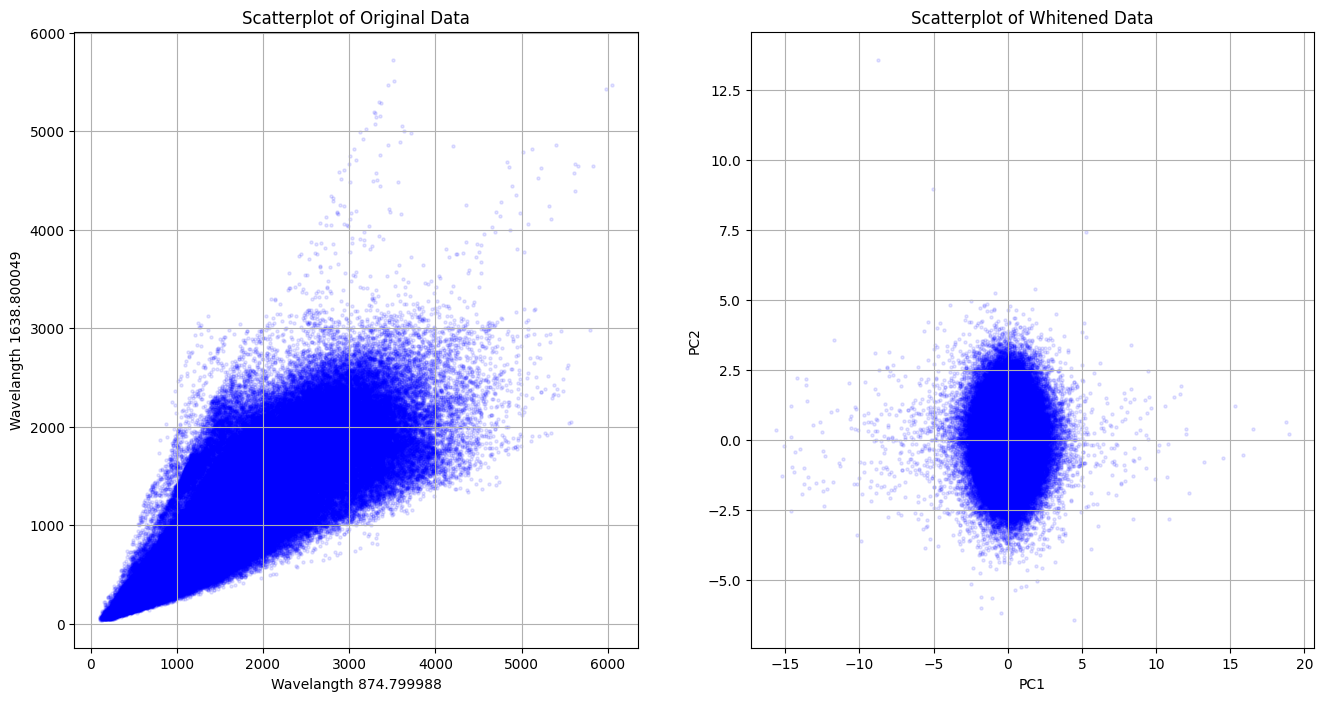

In [32]:
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)  
plt.title('Scatterplot of Original Data')
plt.scatter(imList[:,30],imList[:,80], s=5, c='b', alpha=0.1)
plt.xlabel(f'Wavelangth {wl[30]}')
plt.ylabel(f'Wavelangth {wl[80]}')
plt.grid(True)

plt.subplot(1, 2, 2)  
plt.title('Scatterplot of Whitened Data')
plt.scatter(WimList[:,30],WimList[:,80], s=5, c='b', alpha=0.1)
plt.xlabel(f'PC1')
plt.ylabel(f'PC2');
plt.grid(True)

NameError: name 'imSpec_Gr' is not defined

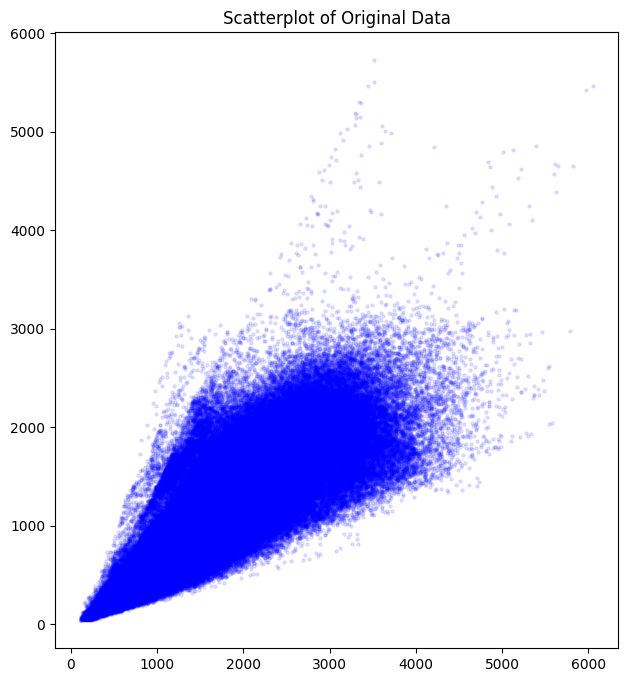

In [33]:
# add the locations of the three spectra to these plots
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)  
plt.title('Scatterplot of Original Data')
plt.scatter(imList[:,30],imList[:,80], s=5, c='b', alpha=0.1)
plt.scatter(imSpec_Gr[30], imSpec_Gr[80], c='g', s=20, label='Image Pixel Grass')
plt.scatter(imSpec_F1[30], imSpec_F1[80], c='r', s=20, label='Image Pixel F1')
plt.scatter(spec_F1[30], spec_F1[80], c='r', s=20, marker='x', label='Library Spectrum F1')
plt.legend()
plt.xlabel(f'Wavelangth {wl[30]}')
plt.ylabel(f'Wavelangth {wl[80]}')
plt.grid(True)

PC1 = 30
PC2 = 61
plt.subplot(1, 2, 2)  
plt.title('Scatterplot of Whitened Data')
plt.scatter(WimList[:,PC1],WimList[:,PC2], s=5, c='b', alpha=0.1)
plt.scatter(WimSpec_Gr[PC1], WimSpec_Gr[PC2], c='g', s=20, label='Image Pixel Grass')
plt.scatter(WimSpec_F1[PC1], WimSpec_F1[PC2], c='r', s=20, label='Image Pixel F1')
plt.scatter(Wspec_F1[PC1], Wspec_F1[PC2], c='r', s=20, marker='x', label='Library Spectrum F1')
plt.legend()
plt.xlabel(f'PC1')
plt.ylabel(f'PC2');
plt.grid(True)

## Observation: We often say that 'target detection detects pixels that are way from the mean in whitened-space, but in the direction of the target'. This plot demonstrates that concept.

Text(0.5, 1.0, 'Histogram of Whitened Spectra, Band 5\n NOTE: This in theory should be a normal distribution.')

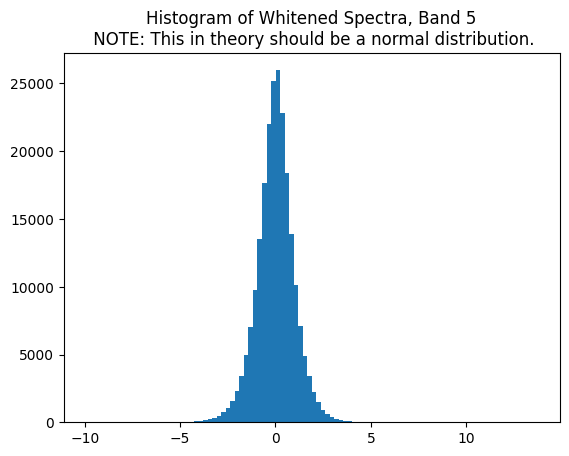

In [ ]:
i = 5
plt.hist(WimList[:,i].flatten(), bins=100);
plt.title(f'Histogram of Whitened Spectra, Band {i}\n NOTE: This in theory should be a normal distribution.')

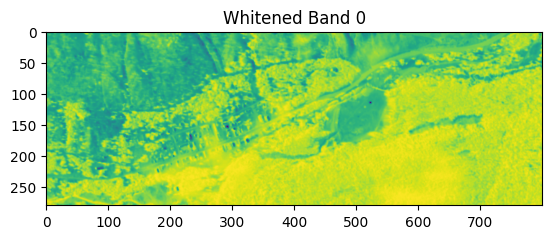

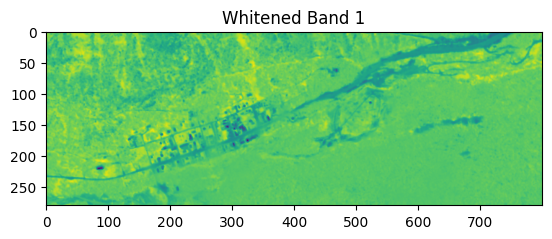

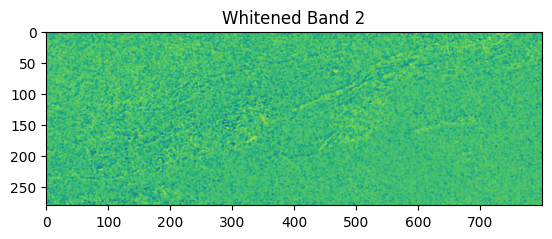

In [ ]:
for i in range(3):
    plt.figure()
    plt.imshow(np.reshape(WimList[:,i], (im.nrows,im.ncols)))
    plt.title(f'Whitened Band {i}')

Fig 4 caption: "Plots of the image data projected from whitened space with false alarms for ACE shown in
 green. The vertical axis is adjacent side and the horizontal axis is opposite side from Eq. (8). The
 highest scoring target pixel from the ground truth is shown in red. The false alarms—pixels scoring
 greater than the highest scoring target pixel from the ground truth—are shown in green. For the
 fabric panels additional ground truth target pixels are shown in teal. The number of false alarms is
 provided in the title for each plot."

hyp = sqrt(X dot X)
adj = T dot X / sqrt(T dot T)
opp = sqrt(hyp^2 - adj^2)
MF = adj/mag(T)

In [27]:
print(list(enumerate(names)))

[(0, 'V3_field_spectrum'), (1, 'V2a_field_spectrum'), (2, 'V2b_field_spectrum'), (3, 'V1_field_spectrum'), (4, 'F7_field_spectrum'), (5, 'F7_Cloth_Green'), (6, 'F6_field_spectrum'), (7, 'F6_Nylon_Silver'), (8, 'F5_field_spectrum'), (9, 'F5_Nylon_Maroon'), (10, 'F4_field_spectrum'), (11, 'F4_Nylon_Maroon'), (12, 'F3_field_spectrum'), (13, 'F3_Cloth_Blue'), (14, 'F2_field_spectrum'), (15, 'F2_Nylon_Yellow'), (16, 'F1_field_spectrum'), (17, 'F1_Cloth_Red')]


In [14]:
lib_F1 = spec[17,:]
lib_F2 = spec[15,:]
lib_F3 = spec[13,:]
lib_V1 = spec[3,:]
lib_V2 = spec[1,:]
lib_V3 = spec[0,:]

In [15]:
sqrt_t_dot_t.shape

(18,)

In [16]:
adj = x_dot_t / sqrt_t_dot_t
opp = np.sqrt(hyp**2 - adj**2)

In [34]:
adj.shape

(224000, 18)

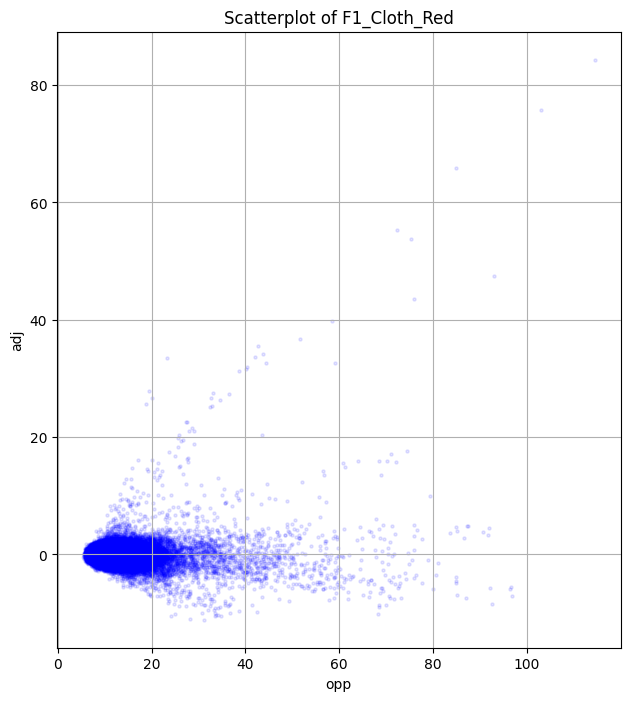

In [ ]:
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)  
plt.title(f'Scatterplot of {names[17]}')
plt.scatter(opp[:,17],adj[:,17], s=5, c='b', alpha=0.1)
plt.xlabel(f'opp')
plt.ylabel(f'adj')
plt.grid(True)

#
